In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy import stats
import seaborn as sns

from data_loading import (load_m1h_activation_data,
                          load_annotated_TFiso1_collection)

In [2]:
tfs = load_annotated_TFiso1_collection()
m1h = load_m1h_activation_data()
m1h['mean'] = m1h[['M1H_rep1', 'M1H_rep2', 'M1H_rep3']].mean(axis=1)
m1h['iso_acc'] = m1h['clone_acc'].apply(lambda x: x.split('|')[0] + '-' + x.split('|')[1].split('/')[0])

reading from cache


In [3]:
from data_loading import load_tf_families
df = pd.DataFrame([(tf_name, tf.isoforms[0].name, alt_iso.name) for tf_name, tf in tfs.items() for alt_iso in tf.isoforms[1:]],
                    columns=['gene_symbol', 'ref_iso', 'alt_iso'])
tf_fam = load_tf_families()
df['DBD'] = df['gene_symbol'].map(tf_fam)
df['m1h_ref'] = df['ref_iso'].map(m1h.set_index('iso_acc')['mean'])
df['m1h_alt'] = df['alt_iso'].map(m1h.set_index('iso_acc')['mean'])

In [4]:
m1h['DBD'] = m1h['gene_symbol'].map(tf_fam)
df['n_aa_diff'] = df.apply(lambda x: len(tfs[x['gene_symbol']][x['ref_iso']].aa_seq) - len(tfs[x['gene_symbol']][x['alt_iso']].aa_seq), axis=1)
print((df['n_aa_diff'] < 1).sum(), 'n_aa_diff < 1')
# HACK
df['n_aa_diff'] = df['n_aa_diff'].abs()
df['pct_aa_diff'] = (df.apply(lambda x: (len(tfs[x['gene_symbol']][x['ref_iso']].aa_seq) - len(tfs[x['gene_symbol']][x['alt_iso']].aa_seq)) / len(tfs[x['gene_symbol']][x['ref_iso']].aa_seq), axis=1) * 100).abs()

226 n_aa_diff < 1


In [5]:
dbd_to_plot = df['DBD'].value_counts().index[:9]

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


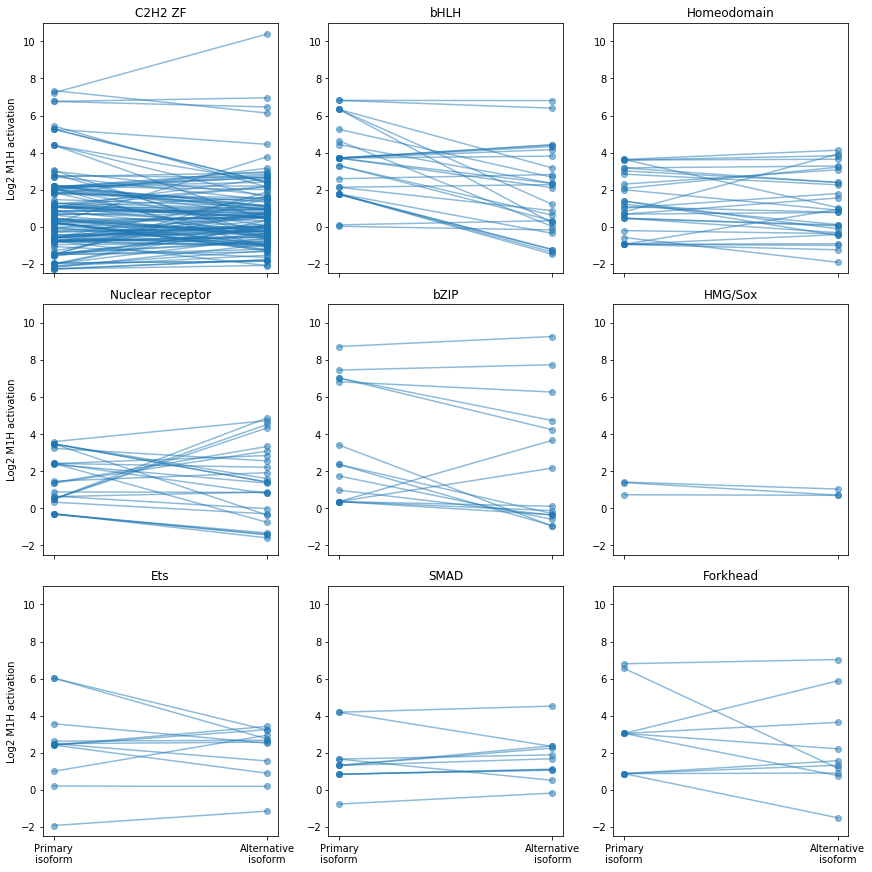

In [6]:
fig, axs = plt.subplots(3, 3)
fig.set_size_inches(4 * 3, 4 * 3)
for family, ax in zip(dbd_to_plot, axs.flatten()):
    for _i, row in df.loc[(df['DBD'] == family) & df['m1h_ref'].notnull() & df['m1h_alt'].notnull(), :].iterrows():
        ax.plot([0, 1], 
                [row['m1h_ref'], row['m1h_alt']],
                'o-',
                color='C0', alpha=0.5)
    ax.set_ylim(-2.5, 11)
    ax.set_xticks([0, 1])

    ax.set_title(family)
for ax in axs[:, 0]:
    ax.set_ylabel('Log2 M1H activation')
for ax in axs[:-1, :].flatten():
    ax.set_xticklabels(['', ''])
for ax in axs[-1, :]:
    ax.set_xticklabels(['Primary\nisoform', 'Alternative\nisoform'])
plt.savefig('../figures/m1h_by-DBD-family_pairplot.pdf',
            bbox_inches='tight')

C2H2 ZF 3.999000153234811
bHLH 0.00010561707345773583
Homeodomain 0.008049158836107845
Nuclear receptor 0.0012159614958710285
bZIP 0.002934300612440041
HMG/Sox 0.07866767729230216
Ets 0.002022305729202092
SMAD 0.03771262026016983
Forkhead 0.006564991660407399


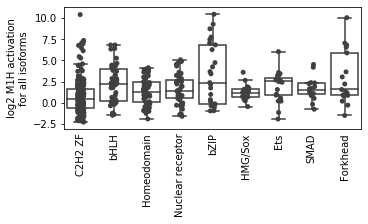

In [7]:
# m1h for all isoforms

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5, 3)
sns.boxplot(data=m1h, x='DBD', y='mean', order=dbd_to_plot, ax=ax, boxprops={'facecolor': 'w'}, fliersize=0)
sns.stripplot(data=m1h, x='DBD', y='mean', order=dbd_to_plot, ax=ax, color='.25')
ax.set_xlabel('')
ax.set_ylabel('log2 M1H activation\nfor all isoforms')
ax.xaxis.set_tick_params(rotation=90, length=0)

# p-values
for dbd in dbd_to_plot:
    print(dbd, stats.mannwhitneyu(m1h.loc[(m1h['DBD'] == 'C2H2 ZF') & m1h['mean'].notnull(), 'mean'].values,
                                  m1h.loc[(m1h['DBD'] == dbd) & m1h['mean'].notnull(), 'mean'].values)[1] * 8)

plt.savefig('../figures/M1H-all_isoforms_by-TF-family_boxplot.pdf',
            bbox_inches='tight')

/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


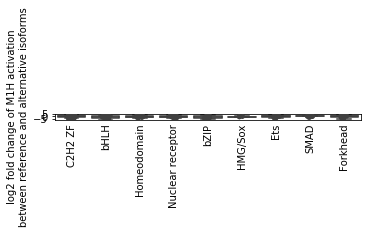

In [8]:
df['m1h_change'] = df['m1h_alt'] - df['m1h_ref']
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5, 3)
sns.boxplot(data=df, x='DBD', y='m1h_change', order=dbd_to_plot, ax=ax, boxprops={'facecolor': 'w'}, fliersize=0)
sns.stripplot(data=df, x='DBD', y='m1h_change', order=dbd_to_plot, ax=ax, color='.25')
ax.set_xlabel('')
ax.set_ylabel('log2 fold change of M1H activation\nbetween reference and alternative isoforms')
ax.xaxis.set_tick_params(rotation=90, length=0)
plt.savefig('../figures/M1H-change_by-TF-family_boxplot.pdf',
            bbox_inches='tight')

C2H2 ZF 3.9974273949832493
bHLH 0.05611515365520313
Homeodomain 2.1461700275604936
Nuclear receptor 0.02826252613665936
bZIP 0.06281889834983735
HMG/Sox 0.706914044908797
Ets 2.070729135196485
SMAD 1.8775282377455507
Forkhead 1.6369598665252392


/PHShome/kz659/.conda/envs/py36/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


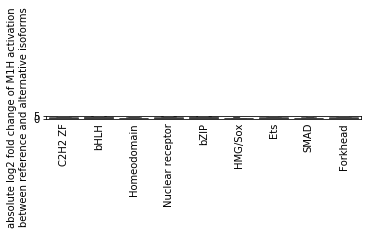

In [9]:
# absolute difference
df['m1h_abs_change'] = (df['m1h_alt'] - df['m1h_ref']).abs()
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5, 3)
sns.boxplot(data=df, x='DBD', y='m1h_abs_change', order=dbd_to_plot, ax=ax, boxprops={'facecolor': 'w'}, fliersize=0)
sns.stripplot(data=df, x='DBD', y='m1h_abs_change', order=dbd_to_plot, ax=ax, color='.25')
ax.set_xlabel('')
ax.set_ylabel('absolute log2 fold change of M1H activation\nbetween reference and alternative isoforms')
ax.xaxis.set_tick_params(rotation=90, length=0)

# p-values
for dbd in dbd_to_plot:
    print(dbd, stats.mannwhitneyu(df.loc[(df['DBD'] == 'C2H2 ZF') & df['m1h_abs_change'].notnull(), 'm1h_abs_change'].values,
                                  df.loc[(df['DBD'] == dbd) & df['m1h_abs_change'].notnull(), 'm1h_abs_change'].values)[1] * 8)

plt.savefig('../figures/M1H-absolute-change_by-TF-family_boxplot.pdf',
            bbox_inches='tight')

In [10]:
from data_loading import DIMERIZING_TF_FAMILIES
df['is_dimerizing_tf'] = df['DBD'].isin(DIMERIZING_TF_FAMILIES)

In [11]:
df.head()

,gene_symbol,ref_iso,alt_iso,DBD,m1h_ref,m1h_alt,n_aa_diff,pct_aa_diff,m1h_change,m1h_abs_change,is_dimerizing_tf
0,ZBTB18,ZBTB18-1,ZBTB18-2,C2H2 ZF,2.153413,2.656826,9,1.694915,0.503414,0.503414,False
1,PRRX1,PRRX1-1,PRRX1-2,Homeodomain,0.679816,1.552087,28,12.903226,0.872271,0.872271,False
2,PRRX1,PRRX1-1,PRRX1-3,Homeodomain,0.679816,0.773129,17,7.834101,0.093313,0.093313,False
3,POU2F1,POU2F1-1,POU2F1-2,Homeodomain; POU,NaN,2.509024,12,1.589404,NaN,NaN,False
4,POU2F1,POU2F1-1,POU2F1-204,Homeodomain; POU,NaN,NaN,11,1.456954,NaN,NaN,False


In [12]:
len(df)

1067

In [13]:
len(df[~pd.isnull(df['m1h_abs_change'])])

326

In [17]:
df[~pd.isnull(df['m1h_abs_change'])].is_dimerizing_tf.value_counts()

False    212
True     114
Name: is_dimerizing_tf, dtype: int64

In [21]:
df.sort_values(by="m1h_abs_change", ascending=False).head()

,gene_symbol,ref_iso,alt_iso,DBD,m1h_ref,m1h_alt,n_aa_diff,pct_aa_diff,m1h_change,m1h_abs_change,is_dimerizing_tf
271,E2F3,E2F3-2,E2F3-3,E2F,6.444157,-0.989488,93,27.352941,-7.433645,7.433645,True
248,TBPL1,TBPL1-1,TBPL1-2,TBP,7.110312,0.246030,23,12.365591,-6.864281,6.864281,False
353,TFEC,TFEC-1,TFEC-3,bHLH,6.330644,0.198317,31,8.933718,-6.132327,6.132327,True
547,FOXJ2,FOXJ2-1,FOXJ2-2,Forkhead,6.550576,1.167440,48,8.362369,-5.383136,5.383136,False
356,TFEC,TFEC-1,TFEC-6,bHLH,6.330644,1.201684,151,43.515850,-5.128960,5.128960,True


In [19]:
df.m1h_abs_change.max()

7.433645243118278

In [14]:
from statannotations.Annotator import Annotator

0.004520406337785872
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

True vs. False: P = 0.005


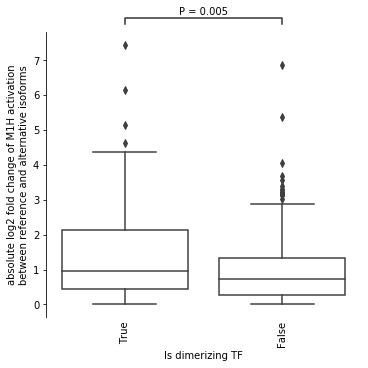

In [16]:
# absolute difference
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(w=5, h=5)
sns.boxplot(data=df, x='is_dimerizing_tf', y='m1h_abs_change', order=[True, False], ax=ax, boxprops={'facecolor': 'w'})#, fliersize=0)
#sns.stripplot(data=df, x='is_dimerizing_tf', y='m1h_abs_change', order=[True, False], ax=ax, color='.25')
ax.set_xlabel('Is dimerizing TF')
ax.set_ylabel('absolute log2 fold change of M1H activation\nbetween reference and alternative isoforms')
ax.xaxis.set_tick_params(rotation=90, length=0)
for loc in ['bottom', 'right', 'top']:
    ax.spines[loc].set_visible(False)

# p-value
pval = stats.mannwhitneyu(df.loc[df['is_dimerizing_tf'] & df['m1h_abs_change'].notnull(), 'm1h_abs_change'].values,
                          df.loc[~df['is_dimerizing_tf'] & df['m1h_abs_change'].notnull(), 'm1h_abs_change'].values)[1]
print(pval)
annotator = Annotator(ax=ax, pairs=[(True, False)], data=df, x='is_dimerizing_tf', y='m1h_abs_change', order=[True, False],)
annotator.configure(loc='outside')
# TODO: set this programmatically
annotator.annotate_custom_annotations(['P = {:.3f}'.format(pval)])
plt.savefig('../figures/M1H-absolute-change_by-dimerizing-TF-family_boxplot.pdf',
            bbox_inches='tight')

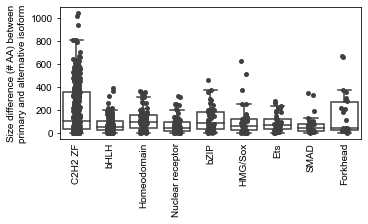

In [9]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5, 3)
sns.boxplot(data=df, x='DBD', y='n_aa_diff', order=dbd_to_plot, ax=ax, boxprops={'facecolor': 'w'}, fliersize=0)
sns.stripplot(data=df, x='DBD', y='n_aa_diff', order=dbd_to_plot, ax=ax, color='.25')
ax.set_xlabel('')
ax.set_ylabel('Size difference (# AA) between\nprimary and alternative isoform')
ax.xaxis.set_tick_params(rotation=90, length=0)

# p-values
#for dbd in dbd_to_plot:
#    print(dbd, stats.mannwhitneyu(df.loc[(df['DBD'] == 'C2H2 ZF') & df['m1h_abs_change'].notnull(), 'm1h_abs_change'].values,
#                                  df.loc[(df['DBD'] == dbd) & df['m1h_abs_change'].notnull(), 'm1h_abs_change'].values)[1] * 8)

plt.savefig('../figures/n-AA-diff_by-TF-family_boxplot.pdf',
            bbox_inches='tight')

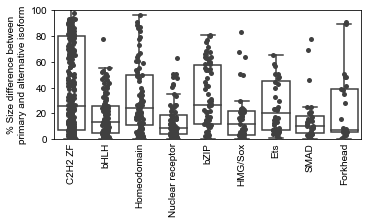

In [10]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5, 3)
sns.boxplot(data=df, x='DBD', y='pct_aa_diff', order=dbd_to_plot, ax=ax, boxprops={'facecolor': 'w'}, fliersize=0)
sns.stripplot(data=df, x='DBD', y='pct_aa_diff', order=dbd_to_plot, ax=ax, color='.25')
ax.set_xlabel('')
ax.set_ylabel('% Size difference between\nprimary and alternative isoform')
ax.xaxis.set_tick_params(rotation=90, length=0)
ax.set_ylim(0, 100)

# p-values
#for dbd in dbd_to_plot:
#    print(dbd, stats.mannwhitneyu(df.loc[(df['DBD'] == 'C2H2 ZF') & df['m1h_abs_change'].notnull(), 'm1h_abs_change'].values,
#                                  df.loc[(df['DBD'] == dbd) & df['m1h_abs_change'].notnull(), 'm1h_abs_change'].values)[1] * 8)

plt.savefig('../figures/pct-AA-diff_by-TF-family_boxplot.pdf',
            bbox_inches='tight')